# Machine Learning at Scale

Since we are continually collecting more data, we should see an imporovement in training results as we obtain greater data volumes. This notebook will look at the trend between amount of data and training accuracy. 

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from lib.util import load_and_prep_data, test_on_image, evaluate_model
from matplotlib import pyplot as plt
from generator import Generator
from lib import paths

### Get the Data Ready

In [11]:
df_trim = load_and_prep_data(paths.TRAINING_DATA, paths.DATASET)

Found 119661 raw data points!
Loaded 69917 filtered data points!


In [12]:
# reserve recent data for evaluation
cuttoff = '2022-03-13'
cutoff2 = '2022-03-31'
eval_df = df_trim[(df_trim.timestamp > cuttoff) & (df_trim.timestamp < cutoff2)].copy()
training_df = df_trim[(df_trim.timestamp < cuttoff) | (df_trim.timestamp > cutoff2)].copy()
len(eval_df)

3152

In [19]:
# split the training data into training and testing
def train_test_split(d, frac=0.1):
    test = d.sample(frac=frac, axis=0)
    train = d.drop(index=test.index).sample(frac=1, axis=0)
    return train, test

In [20]:
train_df, test_df = train_test_split(training_df)

### Create the Data Generator for Batch Training

In [21]:
   
    
def create_gen(training_df, validation_df, model_input_shape, color='grayscale'):
    
    train_datagen = image.ImageDataGenerator(
            rescale=1./255,
            #shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True
            )

    test_datagen = image.ImageDataGenerator(rescale=1./255,
                                           )

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=training_df,
            directory=os.path.join(paths.TRAINING_DATA, 'img'),
            x_col='path',
            y_col='weight',
            target_size=model_input_shape,
            batch_size=50,
            class_mode='raw',
            color_mode=color,
            shuffle=True,
            )

    validation_generator = test_datagen.flow_from_dataframe(
            dataframe=validation_df,
            directory=os.path.join(paths.TRAINING_DATA, 'img'),
            x_col='path',
            y_col='weight',
            target_size=model_input_shape,
            batch_size=50,
            class_mode='raw',
            color_mode=color,
            shuffle=True,
            )

    return train_generator, validation_generator

In [22]:
train_generator, val_generator = create_gen(train_df, test_df, (224,224), color='rgb')

Found 60089 validated image filenames.
Found 6676 validated image filenames.


## Training Accuracy vs. Dataset Size
As a general rule, the more data we have for training, the better the model prediction will be. We assume that we will reach a saturation point where the model will no longer get better with more data. Let's see if we can predict where this saturation point will be. We will train the model in several iterations each time using a larger portion of the dataset. This will give us a projection of when saturation will be reached. 

Let's start by getting our model ready. 

In [31]:
import datetime  
%load_ext tensorboard

def gen_model(model_name):
    # load pretrained model
    x_model = tf.keras.applications.xception.Xception(weights='imagenet',
            input_shape=(224, 224, 3),
            include_top=False)
    
    # freez the first n layers
    for layer in x_model.layers[:10]:
        layer.trainable = False
        
    # build new layers
    input_layer = tf.keras.Input(shape=(224, 224, 3))


    # use the whole model and add a couple layers
    x = x_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout

    bias_init = tf.keras.initializers.Constant(train_df.weight.mean())

    outputs = tf.keras.layers.Dense(1, bias_initializer=bias_init)(x) # reduce to one node for weight prediction
    model = tf.keras.Model(input_layer, outputs)
    
    #optimizer
    steps_per_epoch = 200
    model_name = 'iceptres_freeze_adagrad'

    first_decay_steps = 10*steps_per_epoch
    t_mul = 2
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecayRestarts(0.001, first_decay_steps, t_mul=t_mul)
    opt = tf.keras.optimizers.Adagrad(learning_rate=lr_decayed_fn)

    # compile model
    model.compile(
        loss= "mean_squared_error" , 
        optimizer=opt, 
        metrics=["mean_squared_error"])
    return model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Training Loop

We will train the model on 7 different sizes of the dataset. The checkpoint callback will save the best models so we can test them later. 

In [2]:
data_sizes = [5000, 10000, 20000, 30000, 40000, 50000, 60000]

In [ ]:
# Training loop 

for data_size in data_sizes:
    
    # load the datagenerator
    train_generator, val_generator = create_gen(train_df[:data_size], test_df, (224,224), color='rgb')
    
    # generate the model
    model_name = str(data_size)
    model_xcept = gen_model(model_name)
    
    print("Training on {} images".format(data_size))
    
    # Fit the model
    epochs = 100
    batch_size = 32
    
    # save checkpoints
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./scaling/{}_{}_{}'.format(model_name, "{epoch}", "{val_loss}"),
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

    # show on tensorboard
    logs_base_dir = "./scaling_logs"
    logdir = os.path.join(logs_base_dir, model_name + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    
    history = model_xcept.fit(
        train_generator,
        steps_per_epoch=data_size//epochs//batch_size*20,  # the steps need to be limited with less data
        initial_epoch=1,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=10,
        shuffle=True,
        callbacks=[checkpoint_callback, tensorboard_callback]
        )
    
    # unfreeze layers and continue training
    for layer in model_xcept.layers[:10]:
        layer.trainable = True
    
    history = model_xcept.fit(
        train_generator,
        steps_per_epoch=data_size//epochs//batch_size*20,
        initial_epoch=100,
        epochs=epochs*2,
        validation_data=val_generator,
        validation_steps=10,
        shuffle=True,
        callbacks=[checkpoint_callback, tensorboard_callback]
        )
    
   

### Evaluate Models
We will evaluate the models using the `evaluate_model` function I built in the utilities module. We will store the results of the evaluation in a dataframe to look at later. 

In [3]:
def loss_from_name(s):
    return s.split('_')[-1]

def data_size_from_name(s):
    return s.split('_')[0]

In [14]:
from importlib import reload
import lib
reload(lib.util)
from lib.util import test_on_image, load_and_prep_data, evaluate_model

In [15]:
# Evaluate the best model from each sample size
import pandas as pd

test_group = pd.DataFrame()
results_df = pd.DataFrame()
results_df['name'] =  os.listdir('./scaling/')
results_df['loss'] = results_df.name.apply(loss_from_name)
results_df['data_size'] = results_df.name.apply(data_size_from_name)
results_df['path'] = 'scaling/' + results_df.name
print(results_df.head())

for data_size in data_sizes:
    
    # lets look at the best 5 models for each data_size
    df = results_df[results_df.data_size == str(data_size)].sort_values(by='loss', ascending=True)[:5]
    
    test_group = pd.concat([test_group, df])

# run the evaluation on every model in the test_group  
results_df = test_group.path.apply(evaluate_model) 

                               name             loss data_size
0   scaling/10000_10_35353.23046875   35353.23046875     10000
1  scaling/10000_11_28268.509765625  28268.509765625     10000
2  scaling/10000_13_27454.998046875  27454.998046875     10000
3  scaling/10000_14_24756.685546875  24756.685546875     10000
4     scaling/10000_19_23264.796875     23264.796875     10000
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

5000_76_17712.419921875 average accuracy: 84.92%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

5000_66_19410.48828125 average accuracy: 85.07%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

5000_52_20055.056640625 average accuracy: 84.38%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

5000_50_22423.849609375 average accuracy: 84.94%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

5000_48_23248.87109375 average accuracy: 85.02%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

10000_66_14852.546875 average accuracy: 86.20%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

10000_63_16244.857421875 average accuracy: 86.76%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

10000_59_17557.69140625 average accuracy: 86.51%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

10000_55_18241.603515625 average accuracy: 87.07%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

10000_52_18512.857421875 average accuracy: 86.53%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

20000_169_13004.7041015625 average accuracy: 87.76%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

20000_159_13928.0458984375 average accuracy: 87.16%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

20000_157_14243.244140625 average accuracy: 87.37%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

20000_66_14260.8837890625 average accuracy: 87.50%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

20000_63_15425.2841796875 average accuracy: 88.09%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

30000_59_11236.9716796875 average accuracy: 87.85%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

30000_44_12316.6181640625 average accuracy: 88.26%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

30000_34_12887.4697265625 average accuracy: 87.13%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

30000_23_13462.4599609375 average accuracy: 86.44%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

30000_22_14957.9765625 average accuracy: 87.37%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

40000_103_10710.6611328125 average accuracy: 88.32%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

40000_82_10833.8173828125 average accuracy: 88.38%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

40000_60_11826.94140625 average accuracy: 87.51%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

40000_50_12918.5556640625 average accuracy: 87.52%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

40000_47_13213.708984375 average accuracy: 87.63%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

50000_51_11082.3427734375 average accuracy: 86.61%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

50000_42_12046.3994140625 average accuracy: 87.84%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

50000_39_12120.244140625 average accuracy: 87.85%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

50000_38_12782.3974609375 average accuracy: 88.10%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

50000_37_13131.9404296875 average accuracy: 87.48%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

60000_57_10541.4482421875 average accuracy: 88.02%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

60000_47_10690.8515625 average accuracy: 88.06%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

60000_46_11216.037109375 average accuracy: 86.85%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

60000_37_11519.7958984375 average accuracy: 87.79%
Found 5 files.
Found 1266 data points!


  0%|          | 0/1266 [00:00<?, ?it/s]

60000_32_12136.94921875 average accuracy: 87.45%


In [16]:
results_df = [a[0] for a in results_df]

In [17]:
results_df = pd.DataFrame(results_df)

In [18]:
results_df.to_csv('results_df.csv')
results_df.head()

,name,accuracy,error_mean,error_std,error_min,error_max
0,5000_76_17712.419921875,84.915030,-10.923433,128.320207,-477.694275,589.165588
1,5000_66_19410.48828125,85.073449,-3.844661,128.302385,-485.398926,590.606567
2,5000_52_20055.056640625,84.383710,-18.997413,130.619890,-519.142212,629.373291
3,5000_50_22423.849609375,84.943909,13.281422,130.485439,-542.717651,610.617432
4,5000_48_23248.87109375,85.022513,22.277715,132.846007,-567.383911,639.676025


In [35]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        35 non-null     object 
 1   accuracy    35 non-null     float64
 2   error_mean  35 non-null     float64
 3   error_std   35 non-null     float64
 4   error_min   35 non-null     float64
 5   error_max   35 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.8+ KB


In [33]:
test_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 111 to 125
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       35 non-null     object
 1   loss       35 non-null     object
 2   data_size  35 non-null     object
 3   path       35 non-null     object
dtypes: object(4)
memory usage: 2.4+ KB


In [36]:
results_df = results_df.merge(test_group, on='name')

In [39]:
results_df.loss = results_df.loss.astype(float)
results_df.data_size = results_df.data_size.astype(int)

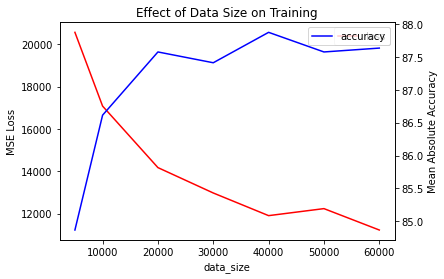

In [57]:
import seaborn as sns
fig = plt.figure() 

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# copy data_size to use for an x axis
results_df['data_amount'] = results_df.data_size


# average the results of each data size
results_df.groupby(by='data_size').mean().plot(y='loss', color='red', ax=ax1)
results_df.groupby(by='data_size').mean().plot(y='accuracy', color='blue', ax=ax2)

ax1.set_ylabel('MSE Loss')
ax2.set_ylabel('Mean Absolute Accuracy')

plt.title('Effect of Data Size on Training')

plt.show();

### Summary
We are using mean squared error to look at the loss: $$ MSE = \sum \limits _{i=0} ^{N} \frac {(y_i - \hat{y_i})^2} {N} $$
Mean absolute accuracy is calculated using the following formula: $$ a = (1 -  \frac{ε} {N}) * 100 \% $$
Where $ ε $ is the residuals of the predictions made: $$ \epsilon =  \sum \limits _{i=0} ^{N} \frac {|y_i - \hat{y_i}|} {y} $$ 

We have trained a Xception network with 7 different sizes of dataset. We evaluated the 5 best models for each data sise and viewed the results. It looks like it is a good idea to have over 20000 images, but we see the signs of diminishing returns as we get to 50-60k datapoints.